# Social networks
Overall project objective was as follows: <b>"Causes of youth violent crime in London: Are opinions on its causes as expressed on Twitter more closely aligned with the ‘facts’, or with the social network to which a tweeter belongs."</b> What we want to assess in this notebook is whether tweeters with the same opinions cluster in the same social groups.




Previously we analysed Twitter data to understand 'WHAT' was being discussed about serious violent crime on Twitter and used that to predict whether the opinion expressed within tweets was 'AGAINST' or 'NOT AGAINST' the causes given by the Mayor. We then used that data to infer the opinion of Twitter users ('tweeters') based on the aggregate opinion expressed across all their tweets.

In this notebook we focus on the 'WHO', which is the communities that are discussing crime and the key influencers within these communities. Having identified these communities we can then see whether there is a relationship between the previsouly derived tweeter opinions and the communities to which they belong. Performing this analysis helps us answer the our second of our research questions, namely: can we identify the social groups to which users rejecting the Mayor’s evidence belong, and whether this view is widely spread within those groups?

Furthermore, performing this comparison also helps us to answer our first research question, which was "Can Twitter sentiment analysis determine the proportions of Twitter users that accept or reject the London Mayor’s evidence that ‘deprivation in the leading cause of youth violent crime in London’?" 


- this is a useful link for academic backup for making the comparison between topic and comminuty https://www.jmir.org/2016/8/e232

Unfortunately, we know the predictive capability is only moderate and the classifier produces quite different results to those we get by manually annotating. However, it is too soon to automatically conclude that it is therefore a poor predictor of tweeter opinion. This is because tweeter opinion is formed by aggregating opinions across all the tweeter's individual tweets and in aggregate form the weight of these tweets might lead to a better predictor of Tweeter opinion. While counterintuitive, this is a key principle in big data mining wherein advocates such as Anand Rajaraman present empirical evidence which suggests more data usually beats better algorithms [5]. The 'usually' is the important factor here, and we will specifically test for this in our next notebook where will will deduce whether the tweeters holding predicted opinions are clustered within similar communities.


We have a body of tweets from which we can understand who is communication with who and by extension which communities exist within our body of tweeters. We also have a set of tweeter screen names, labeled to express whether they hold an opinion 'AGAINST' or 'NOT AGAINST' the London Mayor on the causes of crime. 

## Context




### Network components
Connected components are a subset of nodes in which each node has a minimum of one link with another node in the same subset, and any node that is a member of 'this' subset is not linked to any nodes external to the subset. 

In addition, for <b> directed </b> graphs we can define two types of connected components:
- Weakly connected components, (WCC): maximal set of nodes where there exists a path in at least one direction between each pair of nodes.
- Strongly connected components, (SCC): maximal set of nodes where there exists a path in both directions between each pair of nodes.

And, within these categories we can additionally identify the weakly connected giant (WCGC), which is the largest of the weakly connected components and the strongly connected giant (SCGC), which is the largest of the strongly connected components. In effect these are the largest subgraphs within the network. Bovet et al illustrate this (incorrectly, for SCGC given arrows aren't two way) as follows:

<img src="WCGC-SCGC.png">


we were going to do membership over time but that was on the expectation we could get twitter data spanning 2 years. We don't believe this is beneficial given we only have data for 1 month.

Add as a conclusion:
Strongly connected networks are two way conversations but previously we saw 75% of tweets were retweets and so this suggests the networks are far more one way and so that's why we get more useful results using weakly connected networks.



I basically use two sources for this, Bovet and programminghistorian

What I want to find out is basically the following:
1. Are there obvious social clusters within our network
2. If so, how big are they and how strong are the relationships
3. Within these networks, who are the most important tweeters

We also want to know the following general information:
- Which users are most important, irrespective of network

## Changes I need to make
- Bring strong connections up front - say not really informative but keep an eye out for key players
- Then do overview of degrees and centrality - explain why
- Get components + communities
- Do page ranking - explain why and compare with degrees

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_tweets = pd.read_csv("./DataSources/TwitterData/cleaned_tweets.csv")

In [3]:
print("shape before after dropping rows with all NaN")
print(all_tweets.shape)
all_tweets = all_tweets.dropna(how='all') # only drops a row when every column is NA

print(all_tweets.shape)

# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]
print(nan_values.count())

shape before after dropping rows with all NaN
(41706, 26)
(41706, 26)
index                           41651
tweet_id                        41651
tweet_date                      41651
tweeter_id                      41651
tweeter_user_name               41651
tweeter_screen_name             41651
tweeter_location                41651
message_text                    41651
in_reply_to_user_screen_name     4607
quote_tweet_screen_name           747
favourite_count                 41651
retweet_count                   41651
is_retweet                      41651
extract_run_date                41651
retrieved_using_search_term     41651
retweeted                       41651
mentioned                       41651
hashtags                        41651
Tweet_punct                     41651
Tweet_tokenized                 41651
Tweet_nonstop                   41651
Tweet_lemmatized                41651
Clean_MessageText               41610
tweet_date_dt                   41651
time_bins_12h     

#### Comments
- Set null values in_reply_to_user_screen_name and quote_tweet_screen_name fields to blanks because it's reasonable to have nothing in these fields
- We know from prior notebooks that some tweets have null clean message text and so just set to blanks as we aren't looking at message text in this notebook

In [4]:
all_tweets.loc[all_tweets['in_reply_to_user_screen_name'].isna(), 'in_reply_to_user_screen_name'] = ''
all_tweets.loc[all_tweets['quote_tweet_screen_name'].isna(), 'quote_tweet_screen_name'] = ''
all_tweets.loc[all_tweets['Clean_MessageText'].isna(), 'Clean_MessageText'] = ''

# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]

nan_values.head()

,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins


## Build interaction network
There are four primary ways in which Twitter users interact: reply to, mention, retweet and quote tweet and we will create a body of interaction from our tweet dataset and use this to create our interation network. In this network, the tweeter will be vertices and the interaction between them will be the edges. Previously, when building our hashtag network, we used bespoke code to derive the strength on the edges by summing the number of times it occured. In this case we will use functions available within NetworkX to achieve the same goal.

What we are trying to 


### This code draws heavily on the work of Bovet
### https://github.com/alexbovet/network_lesson/blob/master/02_Analysis_of_Twitter_Social_Network.ipynb

We will use the python module NetworkX to construct and analyze the social network.

There are four types of interactions between two users in Twitter:
- Retweet
- Quote
- Reply
- Mention

In [5]:
# let's define some functions to extract the interactions from tweets
def string_to_list(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("@", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_list = my_str.split(delimiter)
    return my_list

def getAllInteractions(tweet):
    
    # Get the tweeter
    tweet_id = tweet.tweet_id
    tweeter_id = tweet.tweeter_id
    tweeter_name = tweet.tweeter_screen_name
    
    # a python set is a collection of unique items
    # we use a set to avoid duplicated ids
    interacting_users = set()
    
    # Add person they're replying to
    if tweet.in_reply_to_user_screen_name != '':
        interacting_users.add(tweet.in_reply_to_user_screen_name)
        
    # Add person they quoted
    if tweet.quote_tweet_screen_name != '':
        interacting_users.add(tweet.quote_tweet_screen_name)
    
    # Add person they retweeted
    if len(tweet.retweeted) > 2: # because empty strings will contain []
        retweeted_list = string_to_list(tweet.retweeted)
        for item in retweeted_list:
            interacting_users.add(item)
       
    # Add mentions
    if len(tweet.mentioned) > 2: # because empty strings will contain []
        mentioned_list = string_to_list(tweet.mentioned)
        for item in mentioned_list:
            interacting_users.add(item)
  
    # remove the tweeter if he is in the set
    interacting_users.discard(tweeter_name)
    
    # Return our tweeter and their influencers
    return tweeter_id, tweeter_name, tweet_id, list(interacting_users)

In [6]:
import networkx as nx

# define an empty Directed Graph
# A directed graph is a graph where edges have a direction
# in our case the edges goes from user that sent the tweet to
# the user with whom they interacted (retweeted, mentioned or quoted)
G = nx.DiGraph()

# I need create a list of all interacting users for later
# this is because we know we have tweeters who have been retweeted but
# haven't tweeted themselves - this is a gap in our opinion labelling
# which we address later
all_interacting_users = []

for index, tweet in all_tweets.iterrows():
    
    if (tweet.tweeter_screen_name != 'SadiqKhan') & (tweet.tweeter_screen_name != 'MayorofLondon'):
        tweeter_id, tweeter_name, tweet_id, interactions = getAllInteractions(tweet)
        
        all_interacting_users.extend(interactions)
    
        # add an edge to the Graph for each influencer
        for interact_name in interactions:
        
            # add edges between the two user ids
            # this will create new nodes if the nodes are not already in the network
            # we also add an attribute the to edge equal to the id of the tweet
            G.add_edge(tweeter_name, interact_name, tweet_id=tweet_id)
        
            # add name as a property to each node
            # with networkX each node is a dictionary
            G.nodes[tweeter_name]['name'] = tweeter_name
            G.nodes[interact_name]['name'] = interact_name
            
            
all_interacting_users_set = set(all_interacting_users)

## Start with network characteristics
Based on tutorial from: https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python 
- John R. Ladd, Jessica Otis, Christopher N. Warren, and Scott Weingart, "Exploring and Analyzing Network Data with Python," The Programming Historian 6 (2017), https://doi.org/10.46430/phen0064.

In [7]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 26523
Number of edges: 43031
Average in degree:   1.6224
Average out degree:   1.6224


In [8]:
# On a scale of 0 to 1, where 1 is a dense network
density = nx.density(G)
print("Network density:", density)

Network density: 6.117197787591622e-05


In [9]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [10]:
# the keys are the user_id
nodelist = list(G.nodes.keys())
print(nodelist[:10])

['myerschrismyer1', 'LeslieH24367191', 'emilysheffield', 'NaheedMajeed', 'standardnews', 'basilewitch', 'Short2Cjs', 'DeanCowcher', 'sonya_annie', 'OliverSteinme16']


In [11]:
# each node is itself a dictionary with node attributes as key,value pairs
print(type(G.nodes[nodelist[3]]))
print(G.nodes[nodelist[3]])

<class 'dict'>
{'name': 'NaheedMajeed', 'degree': 6}


In [12]:
from operator import itemgetter
from networkx.algorithms import community 

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [13]:
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('SadiqKhan', 1296)
('MayorofLondon', 933)
('KoolKat1025', 912)
('GBNEWS', 875)
('James_Thorburn', 871)
('NKrankie', 742)
('LeaveEUOfficial', 737)
('LeoKearse', 635)
('LeslieH24367191', 575)
('MartinDaubney', 532)
('standardnews', 522)
('polblonde', 489)
('metpoliceuk', 471)
('LozzaFox', 446)
('BrexitBassist', 433)
('NormanBrennan', 397)
('MickeyD44314901', 390)
('Independent', 377)
('PoliticsForAlI', 365)
('PoliticsJOE_UK', 321)


In [14]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [15]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
('James_Thorburn', 0.00040829501837604746)
('LeslieH24367191', 0.0003547568289868739)
('MickeyD44314901', 0.00023596962431397727)
('Simon_S70', 0.0001915142180710078)
('suemitch2017', 0.00018900059400466578)
('LSadler16861851', 0.00012912684611349665)
('KingBobIIV', 0.00012332620786912316)
('kakiOwakagirl', 0.000108503704615942)
('SilvertownTn', 9.915109609466635e-05)
('simon4124', 8.736642712729378e-05)
('NormanBrennan', 8.726378756912479e-05)
('telesyros', 7.75483522462928e-05)
('TflTruth', 7.654660656436779e-05)
('taxi_leaks', 7.25995016606247e-05)
('Stan_VoWales', 7.005567634729698e-05)
('GarySuter5', 6.102455006655463e-05)
('TX4Silver', 6.03682883035982e-05)
('PaulCra33107260', 5.928704101098548e-05)
('ossien1', 5.609751616259887e-05)
('DonnachadhMc', 5.207822738441689e-05)


In [16]:
#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: James_Thorburn | Betweenness Centrality: 0.00040829501837604746 | Degree: 871
Name: LeslieH24367191 | Betweenness Centrality: 0.0003547568289868739 | Degree: 575
Name: MickeyD44314901 | Betweenness Centrality: 0.00023596962431397727 | Degree: 390
Name: Simon_S70 | Betweenness Centrality: 0.0001915142180710078 | Degree: 98
Name: suemitch2017 | Betweenness Centrality: 0.00018900059400466578 | Degree: 122
Name: LSadler16861851 | Betweenness Centrality: 0.00012912684611349665 | Degree: 18
Name: KingBobIIV | Betweenness Centrality: 0.00012332620786912316 | Degree: 121
Name: kakiOwakagirl | Betweenness Centrality: 0.000108503704615942 | Degree: 6
Name: SilvertownTn | Betweenness Centrality: 9.915109609466635e-05 | Degree: 149
Name: simon4124 | Betweenness Centrality: 8.736642712729378e-05 | Degree: 177
Name: NormanBrennan | Betweenness Centrality: 8.726378756912479e-05 | Degree: 397
Name: telesyros | Betweenness Centrality: 7.75483522462928e-05 | Degree: 40
Name: TflTruth | Betweenness

### Load tweeter opinions and add to network as a node attribute

In [17]:
labeled_users = pd.read_csv('./DataSources/TwitterData/labeled_users.csv')
print(labeled_users.shape)
labeled_users.head()

(23108, 5)


,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label
0,0007_vishi,1.0,0.0,0.0,AGAINST
1,005e5n,0.0,0.0,1.0,NOT_AGAINST
2,007AJSmith,1.0,0.0,1.0,NOT_AGAINST
3,007dmax,0.0,0.0,1.0,NOT_AGAINST
4,007taff,1.0,0.0,0.0,AGAINST


In [89]:
unique_tweeters = all_tweets.tweeter_screen_name.unique()

unique_tweeters_df = pd.DataFrame(unique_tweeters, columns =['tweeter_screen_name'])

all_tweeters = pd.merge(unique_tweeters_df, labeled_users, how='left', left_on='tweeter_screen_name', 
                        right_on='tweeter_screen_name')

all_tweeters.loc[all_tweeters['tweeter_label'].isna(), 'tweeter_label'] = 'NONE'

display(all_tweeters.shape)
all_tweeters.tweeter_label.unique()

23857


(23857, 5)

array(['NOT_AGAINST', 'AGAINST', 'NONE', 'FOR'], dtype=object)

### Labeling tweeters who haven't tweeted but were retweeted
We have an issue becayse we have approximately 4,500 tweeters who have been retweeted but for whom we do not have original tweets in our dataset and so we could not assign an opinion to them. Previously we created 'all_interacting_users_set' and now we use that as the basis for identifying users that were retweeted but didn't tweet, so that we can then review and asign them labels

In [134]:
all_interacting_users = []

for index, tweet in all_tweets.iterrows():
    
    if (tweet.tweeter_screen_name != 'SadiqKhan') & (tweet.tweeter_screen_name != 'MayorofLondon'):
        tweeter_id, tweeter_name, tweet_id, interactions = getAllInteractions(tweet)
        
        all_interacting_users.extend(interactions)
    
all_interacting_users_set = set(all_interacting_users)
len(all_interacting_users), len(all_interacting_users_set)

(46800, 7117)

In [135]:
unique_tweeters_set = set(unique_tweeters)
print("Number of tweeters who have tweeted at least once: {:,}".format(len(unique_tweeters)))
print("Number of tweeters who haven't been retweeted: {:,}".format(len(unique_tweeters_set.difference(all_interacting_users_set))))

retweeted_not_tweeted = all_interacting_users_set.difference(unique_tweeters_set)
print("Number of tweeters who have been retweeted but haven't tweeted: {:,}".format(len(retweeted_not_tweeted)))

retweeted_not_tweeted_list = list(retweeted_not_tweeted)

df_all_interacting_users = pd.DataFrame(all_interacting_users, columns=['tweeter_screen_name'])

Number of tweeters who have tweeted at least once: 23,857
Number of tweeters who haven't been retweeted: 21,164
Number of tweeters who have been retweeted but haven't tweeted: 4,424


In [136]:
df_all_interacting_users_agg = df_all_interacting_users.groupby(["tweeter_screen_name"]).apply(lambda x: x['tweeter_screen_name'].count()).reset_index()
df_all_interacting_users_agg.rename(columns = {0:'count'}, inplace = True)

df_all_interacting_users_agg.sort_values(by='count', ascending=False)[:10]

,tweeter_screen_name,count
3507,SadiqKhan,1548
2625,MayorofLondon,1167
1467,GBNEWS,1013
2292,LeaveEUOfficial,921
2200,KoolKat1025,913
2818,NKrankie,906
1918,James_Thorburn,855
6685,standardnews,639
2309,LeoKearse,637
2315,LeslieH24367191,597


In [137]:
df_retweeted_not_tweeted = pd.DataFrame(retweeted_not_tweeted_list, columns=['tweeter_screen_name'])

df_retweeted_not_tweeted_counts = pd.merge(df_retweeted_not_tweeted, df_all_interacting_users_agg, 
                                           how='inner', left_on='tweeter_screen_name', right_on='tweeter_screen_name')

df_retweeted_not_tweeted_counts.sort_values(by='count', ascending=False)[:20]


,tweeter_screen_name,count
2878,Keir_Starmer,198
812,BorisJohnson,183
2865,PolBlonde,170
757,aceattorneygame,157
1638,pritipatel,134
551,JeremyVineOn5,108
3812,Denis,108
3307,telegraph,97
3552,YouTube,62
852,CraigMurrayOrg,58


#### Comments
The subset of users aren't among those who've been retweeted the most (e.g. MayorOfLondon retweeted 1,548 vs Keir_Starmer retweeted 198 times) and, of this smaller group, many of those who were retweeted most often are public figures and so just set their opinion to 'NOT_AGAINST' i.e. neutral. We do run the risk of mis labeling some users who've been retweeted but, for the reasons we've just laid out, we don't believe this will be material.

In [142]:
df_retweeted_not_tweeted['tweeter_label'] = 'NOT_AGAINST'
retweeted_not_tweeted_dict = dict(zip(df_retweeted_not_tweeted.tweeter_screen_name,df_retweeted_not_tweeted.tweeter_label))

opinions_dict = dict(zip(all_tweeters.tweeter_screen_name,all_tweeters.tweeter_label))

In [145]:
# taken from https://www.geeksforgeeks.org/python-merging-two-dictionaries/
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res


combined_opinions_dict = Merge(opinions_dict, retweeted_not_tweeted_dict)
len(combined_opinions_dict), len(opinions_dict), len(retweeted_not_tweeted_dict)



(28281, 23857, 4424)

In [146]:
# Assign each to an attribute in the network
nx.set_node_attributes(G, combined_opinions_dict, 'opinions')

## Connected components

### Strongly connected components

In [147]:
# this returns a list of set of nodes belonging to the 
# different (strongly) connected components
components_strong = list(nx.strongly_connected_components(G))

# sort the component according to their size
components_strong = list(sorted(components_strong, key=lambda x:len(x), reverse=True))

# make a list with the size of each component
comp_sizes_strong = []
for comp in components_strong:
    comp_sizes_strong.append(len(comp))
    
print("number of strong components: {}".format(len(comp_sizes_strong)))

print("sizes of the ten largest components: {}".format(comp_sizes_strong[:20]))

number of strong components: 26168
sizes of the ten largest components: [31, 22, 12, 11, 10, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3]


In [148]:
from itertools import count

def draw_strongly_connected(idx, components_strong, mapping):

    largest_comp_strong = components_strong[idx]
    LCC_strong = G.subgraph(largest_comp_strong)
    
    nodes = LCC_strong.nodes()
    colors = [mapping[LCC_strong.nodes[n]['opinions']] for n in nodes]
    
    print("number of components in LCC[{}] = {}".format(idx, LCC_strong.number_of_nodes()))

    # let's plot the degree distribution inside the LCC
    degrees = [LCC_strong.degree(n) for n in LCC_strong.nodes()]
    print("number of degrees for each node within LCC[{}] = {}\n".format(idx, degrees))
       
    ## <--- now look at centrality
    betweenValues = nx.betweenness_centrality(LCC_strong)
    
    # betweenValues is a dictionary, let's get the values and keys in separate lists
    values = list(betweenValues.values())
    keys = list(betweenValues.keys())
    
    # find the index of the node with highest betweeness centrality
    highestIndex = np.argmax(values)
    
    #Uses solution in the documentation: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html
    
    print('\n <---- centrality and clustering measures -------> \n')
    print("The node id ", keys[highestIndex], " has the centrality degree of ", values[highestIndex])  
    
    pos = nx.spring_layout(LCC_strong)
    
    plt.figure()

    nx.draw_networkx(LCC_strong, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
    plt.show()

number of components in LCC[0] = 31
number of degrees for each node within LCC[0] = [11, 3, 2, 6, 2, 6, 3, 3, 2, 2, 2, 5, 3, 3, 4, 2, 8, 3, 3, 3, 4, 3, 11, 7, 2, 4, 2, 3, 4, 12, 2]


 <---- centrality and clustering measures -------> 

The node id  Simon_S70  has the centrality degree of  0.578735632183908


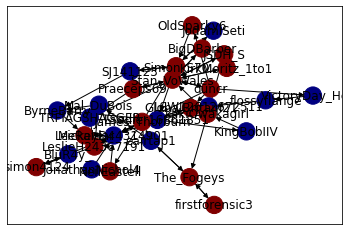

number of components in LCC[1] = 22
number of degrees for each node within LCC[1] = [5, 3, 9, 5, 2, 5, 4, 10, 7, 9, 5, 4, 4, 2, 6, 8, 3, 4, 3, 9, 6, 7]


 <---- centrality and clustering measures -------> 

The node id  telesyros  has the centrality degree of  0.5281746031746032


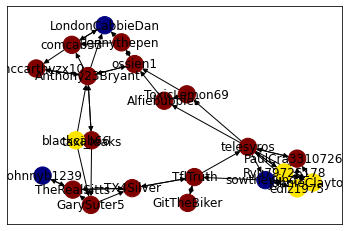

number of components in LCC[2] = 12
number of degrees for each node within LCC[2] = [6, 3, 3, 2, 6, 4, 6, 4, 7, 5, 2, 6]


 <---- centrality and clustering measures -------> 

The node id  OnLondon  has the centrality degree of  0.7272727272727273


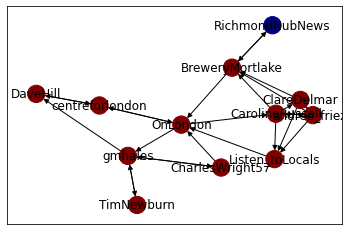

number of components in LCC[3] = 11
number of degrees for each node within LCC[3] = [10, 17, 6, 7, 15, 6, 14, 7, 15, 11, 14]


 <---- centrality and clustering measures -------> 

The node id  Dryadula  has the centrality degree of  0.2314814814814815


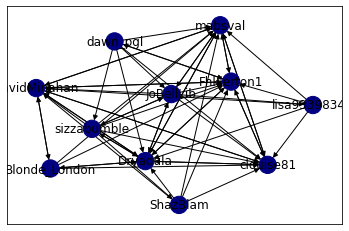

number of components in LCC[4] = 10
number of degrees for each node within LCC[4] = [3, 3, 3, 2, 15, 2, 4, 4, 5, 5]


 <---- centrality and clustering measures -------> 

The node id  SilvertownTn  has the centrality degree of  0.8402777777777777


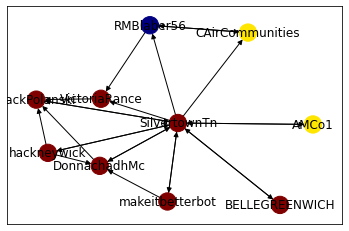

In [149]:
# now set colors
opinions = set(nx.get_node_attributes(G,'opinions').values())
mapping = dict(zip(sorted(opinions),count()))

range_limit = 5
for n in range(range_limit):
    draw_strongly_connected(n, components_strong, mapping)

### Weakly connected components

In [150]:
#1.  this returns a list of set of nodes belonging to the 
# different (weakly) connected components
components = list(nx.weakly_connected_components(G))

# sort the component according to their size
components = list(sorted(components, key=lambda x:len(x), reverse=True))

In [151]:
#2. make a list with the size of each component
comp_sizes = []
for comp in components:
    comp_sizes.append(len(comp))

In [191]:
 #3. # let's make a new graph which is the subgraph of G corresponding to 
# the largest connected component
# let's find the largest component
largest_comp = components[0]
LCC = G.subgraph(largest_comp)   

In [192]:
# 4. 
G.number_of_nodes()

26523

In [193]:
# 5. 
LCC.number_of_nodes()

20801

In [194]:
# 6. let's plot the degree distribution inside the LCC
degrees = [LCC.degree(n) for n in LCC.nodes()]
degrees.sort(reverse=True)
degrees[:20]

[1296,
 933,
 912,
 875,
 871,
 742,
 737,
 635,
 575,
 532,
 522,
 489,
 471,
 446,
 433,
 397,
 390,
 377,
 365,
 321]

In [ ]:
#7. 
nodes = LCC.nodes()
colors = [mapping[LCC.nodes[n]['opinions']] for n in nodes]
pos = nx.spring_layout(LCC)
    
plt.figure()

nx.draw_networkx(LCC, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=300, cmap=plt.cm.jet)
plt.show()


print(mapping)
print(colors)

## Community detection

In [ ]:
H = nx.Graph(G) # need to convert to undirected graph to use greedy_modularity

communities = community.greedy_modularity_communities(H)

In [76]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [85]:
df_community_dict = pd.DataFrame(list(modularity_dict.items()),columns = ['screen_name','class_id']) 
class_list = df_community_dict.class_id.unique()

print("Number of different communities = {} ".format(len(class_list)))

df_community_dict_agg = df_community_dict.groupby('class_id').count()

comm_count = 14
print("\nTop {} communities, by number of members".format(comm_count))
df_community_dict_agg.head(comm_count)

Number of different communities = 1669 

Top 14 communities, by number of members


,screen_name
class_id,
0,5213
1,3742
2,1624
3,1019
4,1011
5,782
6,662
7,647
8,540


In [78]:
from matplotlib import pyplot as plt

def print_class_members(class_num, count):

    # First get a list of just the nodes in that class
    class_id = [n for n in G.nodes() if G.nodes[n]['modularity'] == class_num]

    # Then create a dictionary of the eigenvector centralities of those nodes
    class_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class_id}

    # Then sort that dictionary and print the first 5 results
    class_sorted_by_eigenvector = sorted(class_eigenvector.items(), key=itemgetter(1), reverse=True)

    print("\n<--- Modularity Class {} Sorted by Eigenvector Centrality, top {} values --->".format(class_num, count))
    for node in class_sorted_by_eigenvector[:count]:
        print("Name:", node[0], "| Eigenvector Centrality:", node[1])
        
    my_subgraph = G.subgraph(class_id)
    
    # now set colors
    opinions = set(nx.get_node_attributes(my_subgraph,'opinions').values())
    
    mapping = dict(zip(sorted(opinions),count()))
    nodes = my_subgraph.nodes()
    colors = [mapping[my_subgraph.nodes[n]['opinions']] for n in nodes]
    
    pos = nx.spring_layout(my_subgraph)
    
    plt.figure()

    nx.draw_networkx(my_subgraph, pos, nodelist=nodes, node_color=colors, 
                            with_labels=True, node_size=300, cmap=plt.cm.jet)
    plt.show()


### Compare with classes allocated via labeled tweets

In [ ]:
labeled_users = pd.read_csv('./DataSources/TwitterData/labeled_users.csv')
print(labeled_users.shape)
print(labeled_users[labeled_users.tweeter_label=='AGAINST'].shape)
labeled_users.head()

In [79]:
print(df_community_dict.shape)
df_community_dict.head()

(26523, 2)


,screen_name,class_id
0,AndyMeanie,0
1,run8inout,0
2,MaluaBayReiver,0
3,mcadams883,0
4,mjf1982,0


In [80]:
merged_df = pd.merge(labeled_users, df_community_dict, left_on='tweeter_screen_name', right_on='screen_name')
print(merged_df.shape)

(21452, 7)


In [81]:
just_against = merged_df[merged_df.tweeter_label=='AGAINST'].copy()
against_count = just_against.shape[0]
print(just_against.shape)
just_against.head()

(8101, 7)


,tweeter_screen_name,AGAINST,FOR,NOT_AGAINST,tweeter_label,screen_name,class_id
0,0007_vishi,1.0,0.0,0.0,AGAINST,0007_vishi,18
4,007taff,1.0,0.0,0.0,AGAINST,007taff,5
6,02031961pat,6.0,0.0,2.0,AGAINST,02031961pat,0
7,0606Green,6.0,0.0,2.0,AGAINST,0606Green,0
9,07706Mike,2.0,0.0,1.0,AGAINST,07706Mike,0


In [82]:
just_against_sorted = just_against[['AGAINST','class_id']].groupby(['class_id'])['AGAINST'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) 

just_against_sorted['class_pct_of_total'] = just_against_sorted['count'] / against_count

just_against_sorted.reset_index().head(20)

,index,class_id,count,class_pct_of_total
0,0,0,2875,0.354894
1,1,1,690,0.085175
2,9,9,451,0.055672
3,5,5,409,0.050488
4,2,2,387,0.047772
5,13,13,261,0.032218
6,4,4,242,0.029873
7,11,11,194,0.023948
8,15,15,186,0.022960
9,18,18,165,0.020368


### Comments
We have 5,011 in combined dataframe and approximately 65% of these fall into the classes: 0, 1, 9, 5, 2, 13, 4 and 11

Now we take a look at these classes to see their membership and whether they correlate.

n.b. group by logic above courtesy of https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas

In [254]:
class_list = [0, 1, 9, 5, 2, 13, 4, 11]
top_member_count = 10

for class_id in class_list:
    print("<----- class {} ----->".format(class_id))
    print_class_members(class_id, top_member_count)


<----- class 0 ----->

<--- Modularity Class 0 Sorted by Eigenvector Centrality, top 10 values --->
Name: LeaveEUOfficial | Eigenvector Centrality: 0.00042193601937126136
Name: MickeyD44314901 | Eigenvector Centrality: 0.00038152733612345507
Name: NKrankie | Eigenvector Centrality: 0.00034516763409579075
Name: LeslieH24367191 | Eigenvector Centrality: 0.0003202487691128611
Name: James_Thorburn | Eigenvector Centrality: 0.0003018538345979441
Name: KhanMustGo | Eigenvector Centrality: 0.00025351475529894864
Name: telegraph | Eigenvector Centrality: 0.00022814657864916182
Name: HarrietSergeant | Eigenvector Centrality: 0.00022329136712941612
Name: NormanBrennan | Eigenvector Centrality: 0.00021956932625420803
Name: suemitch2017 | Eigenvector Centrality: 0.00021016151541037326


TypeError: 'int' object is not callable

In [83]:
df_community_just_against = df_community_dict[df_community_dict.class_id.isin(class_list)].copy()

df_community_just_against_sorted = df_community_just_against.groupby('class_id').count().reset_index()
df_community_just_against_sorted.head(20)

,class_id,screen_name
0,0,5213
1,1,3742
2,2,1624
3,3,1019
4,4,1011
5,5,782
6,6,662
7,7,647
8,8,540
9,9,520


In [84]:
sorted_merged = pd.merge(df_community_just_against_sorted, just_against_sorted, left_on='class_id', right_on='class_id')
sorted_merged['pct_of_class'] = sorted_merged['count'] / sorted_merged['screen_name']

sorted_merged.rename(columns = {'screen_name':'community_count', 
                                'count':'label_count', 
                                'class_pct_of_total':'class_as_pct_all_against_labels',
                                'pct_of_class':'label_as_pct_whole_class'}, inplace = True)

sorted_merged.sort_values(by=['label_as_pct_whole_class'], ascending=False).head(20)

,class_id,community_count,label_count,class_as_pct_all_against_labels,label_as_pct_whole_class
314,878,2,2,0.000247,1.0
218,572,3,3,0.000370,1.0
460,1402,2,2,0.000247,1.0
108,229,6,6,0.000741,1.0
461,1404,2,2,0.000247,1.0
203,518,3,3,0.000370,1.0
102,213,6,6,0.000741,1.0
463,1410,2,2,0.000247,1.0
464,1411,2,2,0.000247,1.0
205,528,3,3,0.000370,1.0


### Also need to see what proportion of NOT_AGAINST fall into these classes

## carry on with bovet

In [ ]:
# edges are contained in a EdgeView with a set-like interface
print(type(G.edges))
print(G.edges())

In [ ]:
# we can see all the edges going out of this node
# each edge is a dictionary inside this dictionary with a key 
# corresponding to the target user_id
e = G.out_edges(nodelist[4], data=True)
print(nodelist[4])
print(e)

In [ ]:
# we can iterate over the out-edges 
for s,t,data in e:
    print(s,t,data)

In [ ]:
G.number_of_nodes()

In [ ]:
G.number_of_edges()

In [ ]:
# dictionary with the degree of all nodes
all_degrees = [G.degree(n) for n in nodelist] # this is the degree for undirected edges
in_degrees = [G.in_degree(n) for n in nodelist]
out_degrees = [G.out_degree(n) for n in nodelist]

In [ ]:
# average degree
2*G.number_of_edges()/G.number_of_nodes()

In [ ]:
import numpy as np
np.array(all_degrees).mean()

In [ ]:
np.array(in_degrees).mean()

In [ ]:
np.array(out_degrees).mean()

In [ ]:
# we want to make a list with (user_id, username, degree) for all nodes
degree_node_list = []
for node in nodelist:
    degree_node_list.append((node, G.nodes[node]['name'], G.degree(node)))
    
print('Unordered user, degree list')    
print(degree_node_list[:10])

# sort the list according the degree in descinding order
degree_node_list = sorted(degree_node_list, key=lambda x:x[2], reverse=True)
print('Ordered user, degree list')    
print(degree_node_list[:10])

In [ ]:
# we need to import matplolib for making plots
# and numpy for numerical computations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Network components
Connected components are a subset of nodes in which each node has a minimum of one link with another node in the same subset, and any node that is a member of 'this' subset is not linked to any nodes external to the subset. 

In addition, for <b> directed </b> graphs we can define two types of connected components:
- Weakly connected components, (WCC): maximal set of nodes where there exists a path in at least one direction between each pair of nodes.
- Strongly connected components, (SCC): maximal set of nodes where there exists a path in both directions between each pair of nodes.

And, within these categories we can additionally identify the weakly connected giant (WCGC), which is the largest of the weakly connected components and the strongly connected giant (SCGC), which is the largest of the strongly connected components. In effect these are the largest subgraphs within the network. Bovet et al illustrate this (incorrectly, for SCGC given arrows aren't two way) as follows:

<img src="WCGC-SCGC.png">

## Strongly connected components

In [ ]:
# this returns a list of set of nodes belonging to the 
# different (strongly) connected components
components_strong = list(nx.strongly_connected_components(G))

# sort the component according to their size
components_strong = list(sorted(components_strong, key=lambda x:len(x), reverse=True))

# make a list with the size of each component
comp_sizes_strong = []
for comp in components_strong:
    comp_sizes_strong.append(len(comp))
    
print("number of strong components: {}".format(len(comp_sizes_strong)))

print("sizes of the ten largest components: {}".format(comp_sizes_strong[:20]))

In [ ]:
def draw_strongly_connected(idx):

    largest_comp_strong = components_strong[idx]
    LCC_strong = G.subgraph(largest_comp_strong)

    print("number of components in LCC[{}] = {}".format(idx, LCC_strong.number_of_nodes()))

    # let's plot the degree distribution inside the LCC
    degrees = [LCC_strong.degree(n) for n in LCC_strong.nodes()]
    print("number of degrees for each node within LCC[{}] = {}\n".format(idx, degrees))
    
    # add weights to the edges based on how many times they are traversed
    print("Weight of edges between each node:\n")
    
    for u, v, d in LCC_strong.edges(data=True):
        d['weight'] = 1
    for u,v,d in LCC_strong.edges(data=True):
        print (u,v,d)
    
    ## <--- now look at centrality
    betweenValues = nx.betweenness_centrality(LCC_strong)
    
    # betweenValues is a dictionary, let's get the values and keys in separate lists
    values = list(betweenValues.values())
    keys = list(betweenValues.keys())
    
    # find the index of the node with highest betweeness centrality
    highestIndex = np.argmax(values)
    
    #Uses solution in the documentation: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html
    
    print('\n <---- centrality and clustering measures -------> \n')
    print("The node id ", keys[highestIndex], " has the centrality degree of ", values[highestIndex])

    overallAverage = []
    # now on to looking at clustering coefficients
    for i in range(0, countComps):
        clustCoeff = nx.clustering( connectedSubgraphs[i])
        coeffVals = list(clustCoeff.values())
        overallAverage.append(np.average(coeffVals))
    
    print ("Average clustering coefficent is: ", np.average(overallAverage))

    ## <--- end of this
    
    
    plt.figure()
    nx.draw_networkx(LCC_strong)
    plt.show()

In [ ]:
range_limit = 5
for n in range(range_limit):
    draw_strongly_connected(n)

## end of strongly connected components
- need to comment on interesting not necessarily for the size of the strong components but mostly because of the prominence of their members in other communities - look at that as part of the weakly connected components plus also the community

In [ ]:
# this returns a list of set of nodes belonging to the 
# different (weakly) connected components
components = list(nx.weakly_connected_components(G))

# sort the component according to their size
components = list(sorted(components, key=lambda x:len(x), reverse=True))

In [ ]:
# make a list with the size of each component
comp_sizes = []
for comp in components:
    comp_sizes.append(len(comp))

In [ ]:
# plot the histogram of component sizes
hist = plt.hist(comp_sizes, bins=100)

In [ ]:
# histogram with logarithmic y scale
hist = plt.hist(comp_sizes, bins=100, log=True)
tx = plt.xlabel('component size')
ty = plt.ylabel('number of components')

In [ ]:
# sizes of the ten largest components
comp_sizes[:10]

In [ ]:
# let's make a new graph which is the subgraph of G corresponding to 
# the largest connected component
# let's find the largest component
largest_comp = components[2]
LCC = G.subgraph(largest_comp)

In [ ]:
G.number_of_nodes()

In [ ]:
LCC.number_of_nodes()

In [ ]:
# let's plot the degree distribution inside the LCC
degrees = [LCC.degree(n) for n in LCC.nodes()]
degrees.sort(reverse=True)
degrees

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_networkx(LCC)
plt.show()

In [ ]:

degree_array = np.array(degrees)
hist = plt.hist(degree_array, bins=100)

In [ ]:

# using logarithmic scales
hist = plt.hist(degree_array, bins=100, log=True)
plt.xscale('log')

In [ ]:
# logarithmic scale with logarithmic bins
N, bins, patches = plt.hist(degree_array, bins=np.logspace(0,np.log10(degree_array.max()+1), 20), log=True)
plt.xscale('log')
tx = plt.xlabel('k - degree')
ty= plt.ylabel('number of nodes')

In [ ]:
# Degree probability distribution (P(k))

# since we have logarithmic bins, we need to
# take into account the fact that the bins 
# have different lenghts when normalizing
bin_lengths = np.diff(bins) # lenght of each bin

summ = np.sum(N*bin_lengths)
normalized_degree_dist = N/summ

# check normalization:
print(np.sum(normalized_degree_dist*bin_lengths))

hist = plt.bar(bins[:-1], normalized_degree_dist, width=np.diff(bins))
plt.xscale('log')
plt.yscale('log')
tx = plt.xlabel('k (degree)')
ty = plt.ylabel('P(k)')

## Find most important Tweeters using Page Rank
PageRank is a generalisation of Google's websearch algorithm, which was originally a method for returning the most important web pages for a given search term. It defined importance as the page which - need to talk about teleporting and surfer stuff - reference this bloke: Gleich, D.F., 2015. PageRank beyond the web. Siam Review, 57(3), pp.321-363.

Also then look at from the perspective of centrality as this tells us which nodes(pages) have most edges in or out



In [ ]:
#teleportation probability
alpha = 0.15

#adjacency matrix
nodelist = list(G.nodes())
A = nx.to_numpy_array(G, nodelist=nodelist)

#diagonal matrix of out degrees
deg_out_vect = np.array([float(max(G.out_degree(n),1)) for n in nodelist])
D_out_inv = np.diag(1/deg_out_vect)

# teleportation transition matrix
N = A.shape[1]
S = np.ones((N,N))*1/N

# full transition matrix
M = (1-alpha)*D_out_inv @ A + alpha*S

# for dangling nodes (nodes without out-edges), we force the random teleportation
dangling_nodes = np.where(A.sum(1) == 0)[0]
M[dangling_nodes,:] = S[dangling_nodes,:]

#initial walker distribution and 1st iteration
p_last = np.ones(N)*1/N
p = np.matmul(p_last, M)

# iterate until sufficient convergence
eps = 1.0e-8
i = 1
while np.linalg.norm(p - p_last, 2) > eps:
        p_last = p
        p = np.matmul(p, M)
        i += 1

print(i)

In [ ]:
pg_ranking = np.array(np.argsort(p)[::-1])

pagerank_values = p[pg_ranking]
nodes_pagerank = [nodelist[r] for r in pg_ranking]
nodes_pagerank[:20]

In [ ]:
names_pagerank = [G.nodes[n]['name'] for n in nodes_pagerank]
names_pagerank[:20]

### Compare page rank with degree
Top 20 nodes by degree:
- ('KoolKat1025', 911)
- ('LeoKearse', 629)
- ('LeaveEUOfficial', 537)
- ('SadiqKhan', 510)
- ('MayorofLondon', 376)
- ('BrexitBassist', 317)
- ('PoliticsJOE_UK', 314)
- ('mariannaspring', 294)
- ('PoliticsForAlI', 240)
- ('LBC', 235)
- ('PrisonPlanet', 230)
- ('NKrankie', 219)
- ('talkRADIO', 210)
- ('TJ_Knight', 192)
- ('metpoliceuk', 171)
- ('ashindestad', 170)
- ('MickeyD44314901', 160)
- ('DJBURNS_was', 160)
- ('Independent', 160)
- ('standardnews', 152)

In [ ]:
hist = plt.bar(np.arange(p.shape[0]),np.sort(p)[::-1])
ty = plt.ylabel('PageRank value')
tx = plt.xlabel('PageRank ranking')

In [ ]:
# pagerank is a probability density
pagerank_values.sum()

In [ ]:
# draw the network of the top 5 nodes
plt.figure(figsize=(10,10))
nx.draw(G, nodelist=nodes_pagerank[:5], node_size=8000*pagerank_values[:5],width=0.5, arrows=False)
plt.show()

In [ ]:
# First let's add the pagerank value as a node attribute
for n, pr in zip(nodes_pagerank,pagerank_values):
    if n in LCC:
        LCC.nodes[n]['page_rank'] = pr

In [ ]:
nodes_pagerank[:5]